### GE Stock

Migrate data

`pg_dump -C -h localhost -U postgres postgres | psql -h 192.168.1.79 -U postgres postgres`

Install psycopg2

`pip install psycopg2`



In [76]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from plotly import __version__
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import pymongo
from pymongo import MongoClient
client = MongoClient('192.168.1.77', 27017)


import json
import psycopg2
from tabulate import tabulate
import pandas as pd
from datetime import datetime

import tensorflow as tf
import numpy as np
rng = numpy.random
%matplotlib inline
from tensorflow.contrib import learn
from tensorflow.python.framework import dtypes
from sklearn.metrics import mean_squared_error, mean_absolute_error

import logging
logging.basicConfig(level=logging.INFO)

try:
    conn = psycopg2.connect("dbname='postgres' user='postgres' host='192.168.1.77' port='5433'")
except Exception, e:
    print "Connection Failed! " + str(e)

Get all the historical pricing information

In [77]:
cur = conn.cursor()
cur.execute("""SELECT * from finance.quote WHERE symbol='GE' ORDER BY date ASC""")

rows = cur.fetchall()

qdates = []
open = []
close = []
high = []
low = []
volume = []
moving = []
lower = []
upper = []
for row in rows:
    qdates.append(row[0])
    open.append(row[1])
    close.append(row[2])
    high.append(row[3])
    low.append(row[4])
    volume.append(row[5])
    moving.append(row[7])
    lower.append(row[8])
    upper.append(row[9])
    
    #print " ", row[0], " ", row[1], " ", row[2]

Plot historical pricing

In [79]:
# Create a trace
trace = go.Candlestick(x=qdates,
                       open=open,
                       high=high,
                       low=low,
                       close=close)

trace2 = go.Bar(
    x = qdates,
    y = volume,
    yaxis='y2',
    marker=dict(
        color='rgb(155,155,155)',
    ),
    opacity=0.4
)

layout = go.Layout(
    title='GE Stock',
    yaxis=dict(
        title='Price'
    ),
    yaxis2=dict(
        title='Volume',
        overlaying='y',
        side='right'
    )
)

data = [trace,trace2]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_candlestick', image='svg')

py.image.save_as(fig, filename='a-simple-plot.png')

from IPython.display import Image
Image('a-simple-plot.png')

PlotlyRequestError: You must be authenticated to generate an image via json.

In [64]:
db = client.news
collections = db.collection_names()
cursor = db.GE.find({})

date = []
fdate = []
sentiment = []
objective = []
positive = []
negative = []

for document in cursor:
        fdate.append(document["date"])
        temp = document['date']
        temp = datetime(year=int(temp[0:4]), month=int(temp[4:6]), day=int(temp[6:8]))
        date.append(temp)
        sentiment.append(document["sentiment"])
        objective.append(document["objective"])
        positive.append(document["positive"])
        negative.append(document["negative"])

Historical news articles based on sentiment +/-, objectivity size, with positive language in green and negative language in red.

In [65]:
opinion = {}
def colors(pos, neg):
    temp = []
    for i in range(0, len(pos)):
        opinion[date[i]] = (pos[i] - neg [i] + sentiment[i])
        if pos[i] < neg[i]:
            temp.append('rgba(0, 255, 0, 0.5)')
        else:
            temp.append('rgba(255, 0, 0, 0.5)')
    return temp
    

trace1 = go.Scatter(
    x = date,
    y = sentiment,
    mode = 'markers',
    marker = dict(
        size = objective*3,
        color = colors(positive, negative),
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

datesSorted = sorted(opinion.keys())
valuesSorted = []
for key in datesSorted:
    valuesSorted.append(opinion[key])
    #print key, " ", opinion[key]

#Cumulative doesn't get us anything    
cumulative = np.cumsum(valuesSorted)

topinion = go.Scatter(
    x = datesSorted,
    y = valuesSorted,
    yaxis='y2',
    mode = 'line'
)

layout = go.Layout(
    title='GE Stock',
    yaxis=dict(
        title='Bias'
    ),
    yaxis2=dict(
        title='Price',
        overlaying='y',
        side='right'
    )
)

data = [trace1, topinion]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic-line')

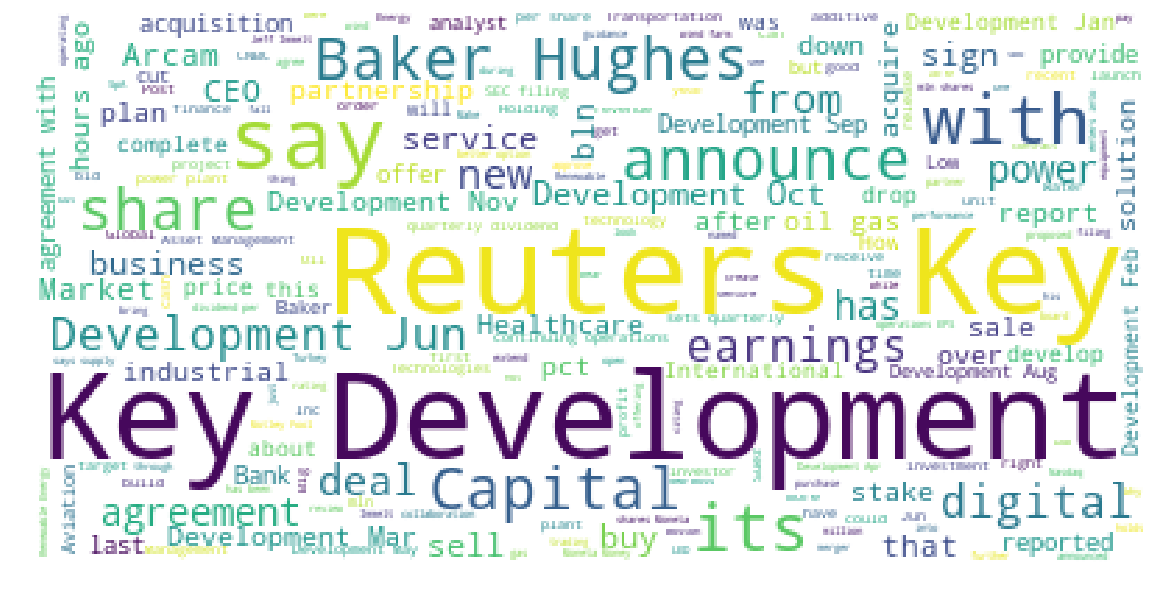

In [66]:
words = []
cursor.rewind()
for document in cursor:
    words += document["title"].split(" ")
    words += document["description"].split(" ")
    
STOPWORDS = ["General", "Electric", "General Electric", "Seeking Alpha", "the", "for", "and", "Alpha", "Company"]
STOPWORDS += ["Stock", "Seeking", "Jul"]
wordlist = [x for x in words if (len(x)>2 and x.isalpha())]
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(" ".join(wordlist))
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [67]:
trace2 = go.Scatter(
    x = qdates,
    y = close,
    yaxis='y2',
    mode = 'line',
    name = 'Price',
    line = dict(
        width = 2,
        color = 'rgb(0, 0, 155)'
    )
)

tmoving = go.Scatter(
    x = qdates,
    y = moving,
    yaxis='y2',
    mode = 'line',
    name = 'Moving avg',
    line = dict(
        width = 2,
        color = 'rgb(0, 100, 0)'
    )
)

tlower = go.Scatter(
    x = qdates,
    y = lower,
    yaxis='y2',
    mode = 'line',
    name = 'Lower',
    line = dict(
        width = 2,
        color = 'rgb(155, 155, 155)'
    )
)

tupper = go.Scatter(
    x = qdates,
    y = upper,
    yaxis='y2',
    mode = 'line',
    name = 'Upper',
    line = dict(
        width = 2,
        color = 'rgb(155, 155, 155)'
    )
)

layout = go.Layout(
    title='GE Stock',
    yaxis=dict(
        title='Bias'
    ),
    yaxis2=dict(
        title='Price',
        overlaying='y',
        side='right'
    )
)

data = [trace1,trace2,tmoving,tupper,tlower]
fig = go.Figure(data=data, layout=layout)

iplot(fig, validate=False)